Timing:                              incl.     excl.
-----------------------------------------------------------
Hamiltonian:                         0.034     0.000   0.0% |
 Atomic:                             0.030     0.000   0.0% |
  XC Correction:                     0.029     0.029   0.0% |
 Calculate atomic Hamiltonians:      0.000     0.000   0.0% |
 Communicate:                        0.000     0.000   0.0% |
 Initialize Hamiltonian:             0.000     0.000   0.0% |
 Poisson:                            0.000     0.000   0.0% |
 XC 3D grid:                         0.004     0.004   0.0% |
LCAO initialization:                 0.238     0.009   0.0% |
 LCAO eigensolver:                   0.027     0.001   0.0% |
  Calculate projections:             0.001     0.001   0.0% |
  DenseAtomicCorrection:             0.003     0.003   0.0% |
  Distribute overlap matrix:         0.000     0.000   0.0% |
  Orbital Layouts:                   0.003     0.003   0.0% |
  Potential matrix:

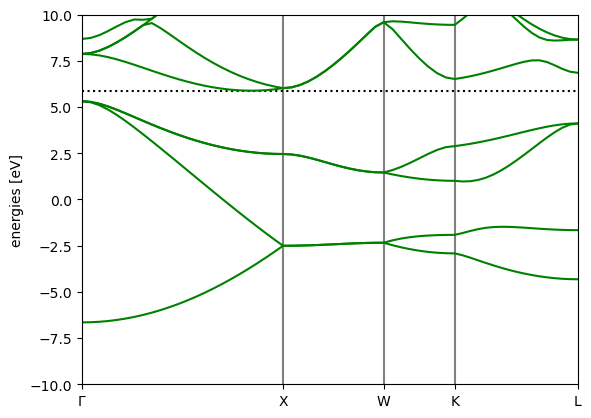

<Axes: ylabel='energies [eV]'>

In [4]:
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac
# Perform standard ground state calculation (with plane wave basis)
si = bulk('Si', 'diamond', 5.43)
calc = GPAW(mode=PW(200),
xc='PBE',
kpts=(8, 8, 8),
random=True, # random guess (needed if many empty bands required)
occupations=FermiDirac(0.01),
txt='Si_gs.txt')
si.calc = calc
si.get_potential_energy()
ef = calc.get_fermi_level()
calc.write('Si_gs.gpw')
# Restart from ground state and fix potential:
calc = GPAW('Si_gs.gpw').fixed_density(
nbands=16,
symmetry='off',
kpts={'path': 'GXWKL', 'npoints': 60},
convergence={'bands': 8})
bs = calc.band_structure()
bs.plot(filename='bandstructure.png', show=True, emax=10.0)


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  25.1.1b1
 |___|_|             

User:   wyl@wyl-Lenovo-Legion-R9000P2021H
Date:   Sat Mar 29 14:57:48 2025
Arch:   x86_64
Pid:    5413
CWD:    /home/wyl/2025
Python: 3.12.7
gpaw:   /home/wyl/anaconda3/lib/python3.12/site-packages/gpaw
_gpaw:  /home/wyl/anaconda3/lib/python3.12/site-packages/
        _gpaw.cpython-312-x86_64-linux-gnu.so (8484859079)
ase:    /home/wyl/anaconda3/lib/python3.12/site-packages/ase (version 3.24.0)
numpy:  /home/wyl/anaconda3/lib/python3.12/site-packages/numpy (version 1.26.4)
scipy:  /home/wyl/anaconda3/lib/python3.12/site-packages/scipy (version 1.13.1)
libxc:  5.2.3
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  experimental: {magmoms: [[0. 0. 0.]
 [0. 0. 0.]],
                 soc: True}
  kpts: [8 8 8]
  mode: {ecut: 400.0,
         name: pw}
  occupations: {fixmagmom: False,
                name: fermi-dirac,
                

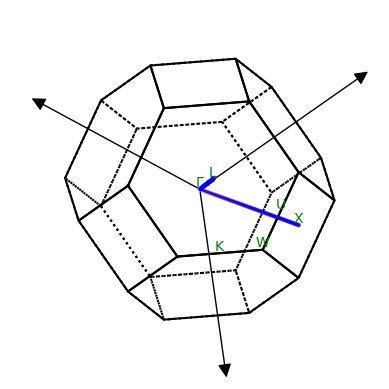

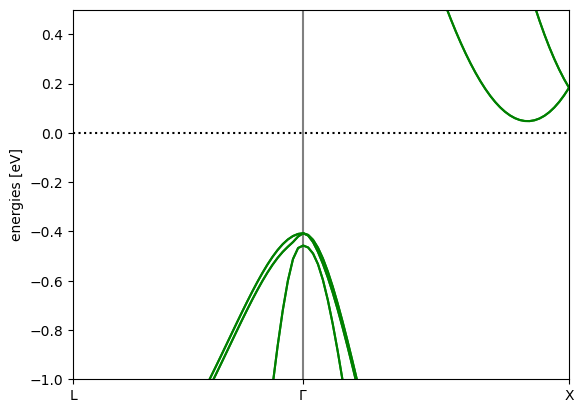

<Axes: ylabel='energies [eV]'>

In [5]:
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac
import numpy as np
# Non-collinear ground state calculation:
si = bulk('Si', 'diamond', 5.43)
si.calc = GPAW(mode=PW(400),
xc='LDA',
experimental={'magmoms': np.zeros((2, 3)),
'soc': True},
kpts=(8, 8, 8),
symmetry='off',
occupations=FermiDirac(0.01))
si.get_potential_energy()
bp = si.cell.bandpath('LGX', npoints=100)
bp.plot()
# Restart from ground state and fix density:
calc2 = si.calc.fixed_density(
nbands=16,
basis='dzp',
symmetry='off',
kpts=bp,
convergence={'bands': 8})
bs = calc2.band_structure()
bs = bs.subtract_reference()
# Zoom in on VBM:
bs.plot(filename='si-soc-bs.png', show=True, emin=-1.0, emax=0.5)

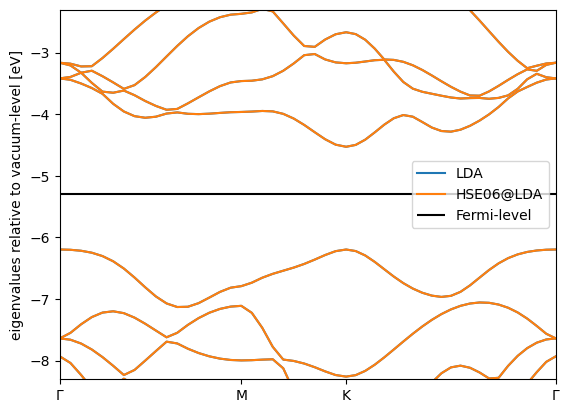

In [21]:
import pickle
from pathlib import Path
from ase.build import mx2
from gpaw.mpi import world
from gpaw.new.ase_interface import GPAW
from gpaw.new.pw.nschse import NonSelfConsistentHSE06
def mos2():
    """Do LDA calculation for MoS2 layer."""
    atoms = mx2(formula='MoS2', kind='2H', a=3.184, thickness=3.13,
                size=(1, 1, 1))
    atoms.center(vacuum=3.5, axis=2)
    k = 6
    atoms.calc = GPAW(mode={'name': 'pw', 'ecut': 400},
                      kpts=(k, k, 1),
                      txt='lda.txt')
    atoms.get_potential_energy()
    return atoms
def bandstructure(gs_calc, bp):
    """Calculate HSE06 bandstructure on top of LDA."""
    fermi_level = gs_calc.get_fermi_level()
    vacuum_level = gs_calc.dft.vacuum_level()
    N = 13 + 4 # 13 occupied + 4 empty
    bs_calc = gs_calc.fixed_density(
        kpts=bp,
        convergence={'bands': N},
        symmetry='off',
        txt='gmkg.txt')
    lda_skn = bs_calc.eigenvalues()
    hse = NonSelfConsistentHSE06.from_dft_calculation(
        gs_calc.dft, 'hse06.txt')
    hse_skn = hse.calculate(bs_calc.dft.ibzwfs, na=0, nb=N)
    # Return energies relative to vacuum level:
    return (lda_skn[0, :, :N] - vacuum_level,
            hse_skn[0] - vacuum_level,
            fermi_level - vacuum_level)
def run():
    atoms = mos2()
    bp = atoms.cell.bandpath('GMKG', npoints=50)
    lda_kn, hse_kn, fermi_level = bandstructure(atoms.calc, bp)
    if world.rank == 0:
        Path('bs.pckl').write_bytes(
            pickle.dumps((bp, lda_kn, hse_kn, fermi_level)))
if __name__ == '__main__':
    run()
# wep-page: hse06.png
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
def plot(bp, lda_kn, hse_kn, fermi_level):
    ax = plt.subplot()
    x, xlabels, labels = bp.get_linear_kpoint_axis()
    labels = [label.replace('G', r'$\Gamma$') for label in labels]
    label = 'LDA'
    for y in lda_kn.T:
        ax.plot(x, y, color='C0', label=label)
        label = None
    label = 'HSE06@LDA'
    for y in hse_kn.T:
        ax.plot(x, y, color='C1', label=label)
        label = None
    ax.hlines(fermi_level, 0.0, x[-1], colors='black', label='Fermi-level')
    ax.legend()
    ax.set_xlim(0.0, x[-1])
    ax.set_ylim(fermi_level - 3.0, fermi_level + 3.0)
    ax.set_xticks(xlabels)
    ax.set_xticklabels(labels)
    ax.set_ylabel('eigenvalues relative to vacuum-level [eV]')
    # plt.show()
    plt.savefig('hse06.png')
if __name__ == '__main__':
    path = Path('bs.pckl')
    plot(*pickle.loads(path.read_bytes()))